In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import gmsh

from funcionesFEM import ResolverSistemaFEM, graficar_armadura1

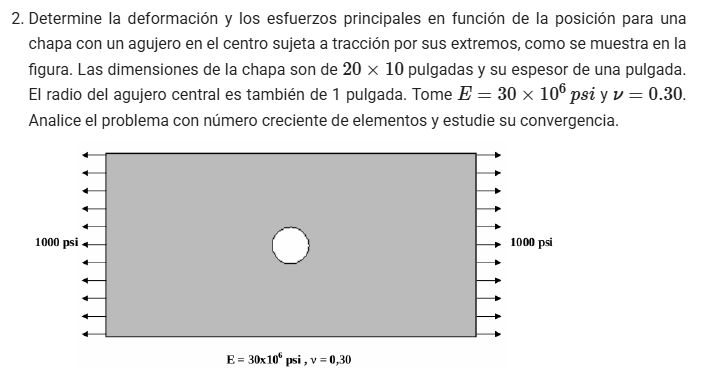

In [2]:
class DATOS:
    def __init__(self, id, largo, ancho, radio, espesor, Tension, ModuloElastico, ModuloPoison, glxn, FactorEscala):
        self.id = id                # Indice del elemento 
        self.largo = largo          
        self.ancho = ancho
        self.radio = radio                 
        self.espesor = espesor               
        self.Tension = Tension             
        self.ModuloElastico = ModuloElastico  
        self.ModuloPoison = ModuloPoison      
        self.glxn = glxn
        self.FactorEscala = FactorEscala    

In [3]:
Dato = DATOS(id=1, largo=10, ancho=5, radio =1, espesor=1, Tension=5000, ModuloElastico=30e6, ModuloPoison=0.3, glxn = 2, FactorEscala = 10000)

In [4]:
#   Lo que se hace ahora es dibujar la pieza con los comandos internos de gmesh

gmsh.initialize()           #   Para inicial gmsh
gmsh.model.add('EJ2-P1')    #   Se arma el modelo

In [5]:
#   Se dibuja la pieza

#   Defino los puntos

escalaMallado = 1

P = [
    gmsh.model.geo.addPoint(0,0,0,escalaMallado),
    gmsh.model.geo.addPoint(0,Dato.ancho,0,escalaMallado),
    gmsh.model.geo.addPoint(Dato.largo,Dato.ancho,0,escalaMallado),
    gmsh.model.geo.addPoint(Dato.largo,0,0,escalaMallado),    
    gmsh.model.geo.addPoint(0,Dato.radio,0,escalaMallado/5),
    gmsh.model.geo.addPoint(Dato.radio,0,0,escalaMallado/5)
]

L = [
    gmsh.model.geo.addLine(P[5],P[3]),
    gmsh.model.geo.addLine(P[3],P[2]),
    gmsh.model.geo.addLine(P[2],P[1]),
    gmsh.model.geo.addLine(P[1],P[4]),
    gmsh.model.geo.addCircleArc(P[4],P[0],P[5])
]

#   Defino las curvas cerradas de mi modelo

C1 = gmsh.model.geo.addCurveLoop([L[0],L[1],L[2],L[3]])
C2 = gmsh.model.geo.addCurveLoop([L[4]])

#   Defino que curvas van a conformar una superficie

S1 = gmsh.model.geo.addPlaneSurface([C1,C2])

gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
#gmsh.fltk.run()

In [6]:
#.........................  SE SACAN LAS MATRICES DE NODOS Y CONECTIVIDADES NECESARIAS ...............................

# ........................  NODOS ....................................................................................
#   Se toma la matriz de nodos 
Nodos = gmsh.model.mesh.get_nodes()         #   Con esto tomo la informacion de los nodos que genera gmesh
numNodos = Nodos[0].shape[0]                #   Con esto tomo la cantidad de nodos que genero gmesh

#   Con esto formo mi matriz de nodos original, se forma como [x,y,z]
MN_original = Nodos[1].reshape(numNodos,3)

#   Defino mi matriz MN tal cual la voy a utilizar en mis funciones, tomo solamente las dos primeras columans [x,y]
MN = MN_original[:, :2]

# ........................  ELEMENTOS ................................................................................

Elementos = gmsh.model.mesh.get_elements_by_type(2)     #   Con esto tomo la informacion de los elementos generados con gmesh 
numElementos = Elementos[0].shape[0]                    #   Con esto tomo la cantidad de elementos que genero gmses

MC_original = Elementos[1].reshape(numElementos,3).astype(int)  #   La notacion con la que se genera esto no es lo indicado. Reformulo para Python

#   Defino mi matriz de conectividades tal cual la voy a utilizar en mi programa
MC = MC_original-1


In [7]:
# fig1, ax1 = plt.subplots(figsize=(10, 6))

# graficar_armadura1(ax1, MN, MC, 'Estructura Original', color='gray', linestyle='-')
    
# plt.tight_layout()
# plt.show()

In [8]:
 #   Se definen los elementos que van a tener propiedades fisicas

EmpotradoX = gmsh.model.addPhysicalGroup(1, [L[3]])
gmsh.model.setPhysicalName(1, EmpotradoX, 'EmpotradoX')

EmpotradoY = gmsh.model.addPhysicalGroup(1, [L[0]])
gmsh.model.setPhysicalName(1, EmpotradoY, 'EmpotradoY')

TraccionadoX = gmsh.model.addPhysicalGroup(1, [L[1]])
gmsh.model.setPhysicalName(1, TraccionadoX, 'TraccionadoX')

Superficie = gmsh.model.addPhysicalGroup(2, [S1])
gmsh.model.setPhysicalName(2, Superficie, 'Superficie')

NodoCentro = gmsh.model.addPhysicalGroup(0, [P[0]])
gmsh.model.setPhysicalName(0, NodoCentro, 'NodoCentro')

In [9]:
#   Como ya tengo la matriz de nodos y conectividades, me queda armar la matriz b que es mi matriz que tiene las condiciones de CC

#.................................................. NODOS EMPOTRADOS .......................................................................................

nodosEmpotradosY = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpotradoY)     # Tomo la infomacion de los nodos sobe la linea que defini como empotrada.
#   Tambien se tiene informacion sobre las coordenadas de estos nodos ... pero no me interesa en este momento

numNodosEmpotrados = nodosEmpotradosY[0].shape[0]

NEy_original = nodosEmpotradosY[0].reshape(numNodosEmpotrados,1).astype(int)        # Tomo los indices de los nodos que me interesan, pero estos no estan en la notacion de Python ...

NEy = NEy_original-1

nodosEmpotradosX = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpotradoX)     # Tomo la infomacion de los nodos sobe la linea que defini como empotrada.
#   Tambien se tiene informacion sobre las coordenadas de estos nodos ... pero no me interesa en este momento

numNodosEmpotrados = nodosEmpotradosX[0].shape[0]

NEx_original = nodosEmpotradosX[0].reshape(numNodosEmpotrados,1).astype(int)        # Tomo los indices de los nodos que me interesan, pero estos no estan en la notacion de Python ...

NEx = NEx_original-1

NCentral = gmsh.model.mesh.get_nodes_for_physical_group(0, NodoCentro)        # Tomo la informacion del nodo central ... que me molesta

NCentral =NCentral[0].astype(int) - 1

# --------------- Esto toma los nodos que considero van a tener condicion de empotramiento ---------------

#.................................................. NODOS TRACCIONADOS .......................................................................................

nodosTraccionados = gmsh.model.mesh.get_nodes_for_physical_group(1,TraccionadoX)     # Tomo la infomacion de los nodos sobe la linea que defini como tracionada.

#   Tambien se tiene informacion sobre las coordenadas de estos nodos ... pero no me interesa en este momento

numNodosTraccionados = nodosTraccionados[0].shape[0]

NT_original = nodosTraccionados[0].reshape(numNodosTraccionados,1).astype(int)        # Tomo los indices de los nodos que me interesan, pero estos no estan en la notacion de Python ...

NT = NT_original-1
NT = np.hstack((NT, np.zeros((NT.shape[0], 1))))    #   Esto es para agregar una columna de ceros ---- 

#print(NCentral)


In [ ]:
#   Este es el bloque mas confuso ... pero si sale (creo)
#   .....................................................................................
entityTraccionada=gmsh.model.getEntitiesForPhysicalGroup(1,TraccionadoX)
Tgroup,Ttraccionada,Ltraccionada=gmsh.model.mesh.getElements(1,entityTraccionada[0])
#   .....................................................................................

#   Ttraccionada: Me devuelve los elementos de mi sistema que estan sobre la linea EmpotradoX ...   #   Se debe pasar a la notacion de PYTHON 
#   LTraccionada: Me devuelve una matriz de conectividades ... con los nodos que estan conectados sobre esa linea ... (Es la que sirve)

Ltraccionada=Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2) #es la matriz de conectividad de los elementos linea del extremo traccionado
Ltraccionada = Ltraccionada - 1 

#   Estraigo la matriz de intereses y la agrupo como matriz ... [nodoi nodoj; .... .... ] Son los nodos que estna conectados sobre la linea de interes

#   .............. MATRIZ QUE GUARDA LA LONGITUD DE LOS ELEMENTOS CONDIDERADOS ..............

#   Como voy a trabajar con cargas distribuidas ... la fuerza no es la misma en los nodos, varia en funcion de la pocision en la linea de interes 

Longitudes=np.abs(MN[Ltraccionada[:,0],1]-MN[Ltraccionada[:,1],1])

In [ ]:
#   Este bloque es para dar un valor de fuerza a cada nodo .... este valor va a depender de la longitud de cada segmento que une dos nodos de la linea de interes
FuerzaT = Dato.Tension / ( Dato.ancho * Dato.espesor )     #   Paso el valor de Tension a fuerza ... Divido por el area

for lin, linea in enumerate(Ltraccionada):        #   Se itera sobre la matriz de conectividades del elemento de interes
    
    #   Tomo los nodos de interes en cada iteracion
    nodo1 = int(linea[0])
    nodo2 = int(linea[1])

    f_nodo = FuerzaT * Longitudes[lin] * Dato.espesor / 2
    
    NT[NT[:,0]==nodo1,1] += f_nodo
    NT[NT[:,0]==nodo2,1] += f_nodo

In [12]:
#   Necesito definir a aquellos nodos sobre los cuales no impuse ninguna condicion ....

NSC = np.arange(numNodos)       #   Creo mi vector para los nodos que no tendran ninguna condicion ....

NSC = NSC[~np.isin(NSC, NEx)]            #   Elimino los nodos empotrados
NSC = NSC[~np.isin(NSC, NEy)]
NSC = NSC[~np.isin(NSC, NCentral)]
NSC = NSC[~np.isin(NSC, NT[:,0])]       #   Elimino los nodos traccionados

In [13]:
#   ....................    AHORA SI ... MI MATRIZ b PARA MIS FUNCIONES .....................................

b = np.zeros([numNodos*2,2])

#   Pimero los nodos co condicion de empotramiento

#   La primera columna me indica el tipo de dato que conozco
#       Si es 0 se conoce la fuerza
#       Si es 1 se conoce el desplazamiento

for i,j in enumerate(NEx):
    b[2*j,0] = 1

for r,t in enumerate(NEy):
    b[2*t+1,0] = 1

for yy,y in enumerate(NCentral):
    b[2*y,0] = 1
    b[2*y+1,0] = 1    

for n,m in enumerate(NT):
    b[int(2*m[0]),1] = m[1]

#print(b)


In [14]:
U,F,elementos = ResolverSistemaFEM(MN,MC,b,Dato,False)

In [15]:
UMatriz = U.reshape(-1, 2)
UMatriz = np.hstack((UMatriz, np.zeros((UMatriz.shape[0], 1))))

TensionMexPE = np.array([e.TensionMax for e in elementos])
TensionX = np.array([e.Tension[0] for e in elementos])
TensionY = np.array([e.Tension[1] for e in elementos])

desplazamientos = gmsh.view.add("Desplazamientos")
gmsh.view.addModelData(desplazamientos, 0, 'EJ2-P1', 'NodeData', Nodos[0], UMatriz, numComponents = 3)

TensionesMaxPE = gmsh.view.add("Tensioes maximas")
gmsh.view.addModelData(TensionesMaxPE, 0, 'EJ2-P1', 'ElementData', Elementos[0], TensionMexPE, numComponents = 1)

TensionesX = gmsh.view.add("Tensioes en X")
gmsh.view.addModelData(TensionesX, 0, 'EJ2-P1', 'ElementData', Elementos[0], TensionX, numComponents = 1)

TensionesY = gmsh.view.add("Tensioes en Y")
gmsh.view.addModelData(TensionesY, 0, 'EJ2-P1', 'ElementData', Elementos[0], TensionY, numComponents = 1)

gmsh.fltk.run()
gmsh.finalize()

